In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_theme()
pd.options.display.max_rows = 500

In [2]:
fields = ['field_overview',
          'field_status',
          'field_operators',
          'field_owners',
          'field_licensees',
          'field_reserves',
          'field_inplaceVol',
          'field_description',
          'comp_reserves',
         ]

In [3]:
from load import load

# Field Licensees

In [4]:
licensees = load(fields[4])

In [5]:
# Current licences don't have a date in 'fldLicenseeTo' field.
curr_lic = licensees[licensees.fldLicenseeTo.isnull()]
data = curr_lic.cmpLongName.value_counts()

## Current Field Licensee Companies

In [6]:
#licence_companies = list(enumerate(curr_lic.cmpLongName.unique(), start=1))
licence_companies = list(enumerate(data.index, start=1))
print(licence_companies)
select = int(input("Select a company by associate number: "))
company = licence_companies[select-1][1]
print("*"*52)
print(f"Selected company is {company}")

[(1, 'Equinor Energy AS'), (2, 'Petoro AS'), (3, 'Vår Energi AS'), (4, 'Total E&P Norge AS'), (5, 'Wintershall Dea Norge AS'), (6, 'Aker BP ASA'), (7, 'ConocoPhillips Skandinavia AS'), (8, 'Neptune Energy Norge AS'), (9, 'Spirit Energy Norway AS'), (10, 'DNO Norge AS'), (11, 'LOTOS Exploration and Production Norge AS'), (12, 'Repsol Norge AS'), (13, 'Idemitsu Petroleum Norge AS'), (14, 'PGNiG Upstream Norway AS'), (15, 'Lundin Energy Norway AS'), (16, 'KUFPEC Norway AS'), (17, 'A/S Norske Shell'), (18, 'OMV (Norge) AS'), (19, 'INEOS E&P Norge AS'), (20, 'Wellesley Petroleum AS'), (21, 'OKEA ASA'), (22, 'Suncor Energy Norge AS'), (23, 'Mime Petroleum AS'), (24, 'DNO North Sea (ROGB) Limited'), (25, 'CapeOmega AS'), (26, 'Petrolia NOCO AS'), (27, 'Pandion Energy AS'), (28, 'Repsol Sinopec Resources UK Limited'), (29, 'Dana Petroleum (BVUK) Limited'), (30, 'Repsol Sinopec North Sea Limited'), (31, 'Sval Energi AS'), (32, 'Edison Norge AS'), (33, 'Total E&P UK Ltd'), (34, 'Waldorf Producti

In [7]:
company.split()[0]

'Lundin'

In [8]:
# Format label strings to only show first word in Company long name
labels = data.index
labelf = [f'{label.split()[0]}' for label in labels]

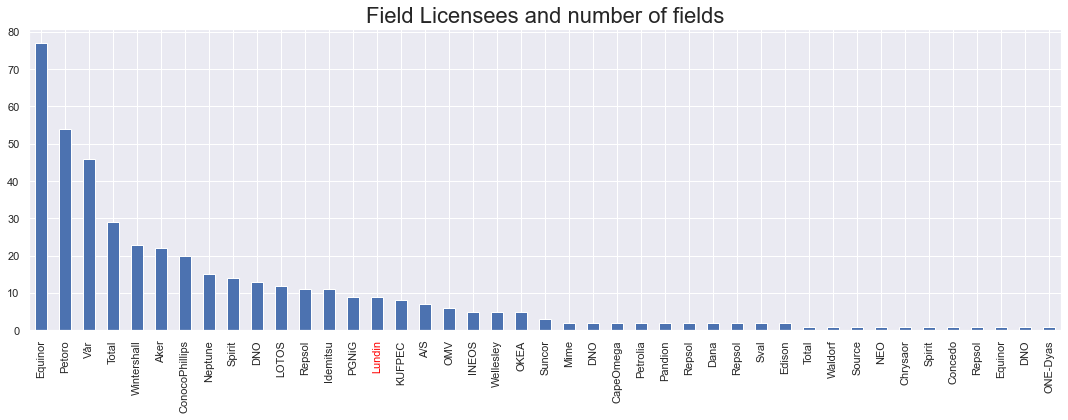

In [9]:
fig, ax = plt.subplots(figsize=(15, 6), tight_layout=True)
data.plot(kind='bar')
ax.xaxis.set_ticklabels(labelf)
plt.xticks(rotation=90); plt.title('Field Licensees and number of fields', fontsize=22)
plt.gca().get_xticklabels()[select-1].set_color('red') 
plt.show()

## Number of Licensees per Field

In [10]:
print(f"Number of Licensees: {licensees['cmpLongName'].nunique()}")
print(f"Number of Fields: {licensees['fldName'].nunique()}")

Number of Licensees: 232
Number of Fields: 124


## Field Licences by selected Company

In [11]:
company_licences = licensees[licensees['cmpLongName']==company]
company_licences = company_licences.loc[company_licences.groupby('fldName').fldLicenseeFrom.idxmax(),:]

In [12]:
company_licences

,fldName,fldOwnerName,fldOwnerKind,fldOwnerFrom,fldOwnerTo,fldLicenseeFrom,fldLicenseeTo,cmpLongName,fldCompanyShare,fldSdfiShare,fldNpdidField,cmpNpdidCompany,fldLicenseeDateUpdated
197,ALVHEIM,203,PRODUCTION LICENSE,2004-10-06,NaN,2020-04-01,NaN,Lundin Energy Norway AS,15.000,NaN,2845712,36998861,2020-04-15
658,BRYNHILD,148,PRODUCTION LICENSE,2011-11-11,NaN,2020-04-01,NaN,Lundin Energy Norway AS,51.000,NaN,21123063,36998861,2020-04-15
687,BØYLA,340,PRODUCTION LICENSE,2012-10-26,NaN,2020-04-01,NaN,Lundin Energy Norway AS,15.000,NaN,22492497,36998861,2020-04-15
1136,EDVARD GRIEG,338,PRODUCTION LICENSE,2012-06-11,NaN,2020-04-01,NaN,Lundin Energy Norway AS,65.000,NaN,21675433,36998861,2020-04-15
2259,GAUPE,292,PRODUCTION LICENSE,2010-06-25,NaN,2020-04-01,NaN,Lundin Energy Norway AS,40.000,NaN,18161341,36998861,2020-04-15
3258,IVAR AASEN,IVAR AASEN UNIT,BUSINESS ARRANGEMENT AREA,2014-06-30,NaN,2020-04-01,NaN,Lundin Energy Norway AS,1.385,NaN,23384520,36998861,2020-04-15
3368,JOHAN SVERDRUP,JOHAN SVERDRUP UNIT,BUSINESS ARRANGEMENT AREA,2015-06-18,NaN,2020-04-01,NaN,Lundin Energy Norway AS,20.000,NaN,26376286,36998861,2020-04-15
5552,SOLVEIG,359,PRODUCTION LICENSE,2019-06-26,NaN,2020-04-01,NaN,Lundin Energy Norway AS,65.000,NaN,34833011,36998861,2020-04-15
8158,VOLUND,150,PRODUCTION LICENSE,2007-01-18,NaN,2020-04-01,NaN,Lundin Energy Norway AS,35.000,NaN,4380167,36998861,2020-04-15


In [13]:
print(f"Number of licences for {company}: {len(company_licences)}")

Number of licences for Lundin Energy Norway AS: 9


In [14]:
company_fields = company_licences['fldName']
company_fields

197            ALVHEIM
658           BRYNHILD
687              BØYLA
1136      EDVARD GRIEG
2259             GAUPE
3258        IVAR AASEN
3368    JOHAN SVERDRUP
5552           SOLVEIG
8158            VOLUND
Name: fldName, dtype: object

# In place volumes

In [15]:
inplacevols = load(fields[6])

In [16]:
# Function to calculate reserves / volumes
def calculate(fields, df, column='fldName'):
    """
    fields: pd.Series.  Need to convert to list in order to iterate.
    df    : DataFrame from which to calculate either In place volumes or Reserves
    column: Column containing the field names, currently 'fldName' but could change from NPD
    """
    volumes = pd.DataFrame()    
    for field in list(fields):        
        if field in list(df[column]):            
            volumes = volumes.append(df[df[column]==field])
            
    volumes.loc['Total'] = volumes.sum(numeric_only=True, axis=0)
    return volumes

## In place volumes for specified Company

In [17]:
company_inplacevols = calculate(company_fields, inplacevols)

In [18]:
company_inplacevols

,fldName,fldInplaceOil,fldInplaceAssLiquid,fldInplaceAssGas,fldInplaceFreeGas,fldDateOffResEstDisplay,fldNpdidField
2,ALVHEIM,109.0,0.0,10.0,11.69,2019-12-31,2845712.0
8,BRYNHILD,6.0,0.0,0.0,0.00,2019-12-31,21123063.0
10,BØYLA,7.0,0.0,1.0,0.00,2019-12-31,22492497.0
16,EDVARD GRIEG,83.0,0.0,10.0,0.00,2019-12-31,21675433.0
27,GAUPE,11.0,1.0,2.0,3.10,2019-12-31,18161341.0
46,IVAR AASEN,47.0,0.0,7.0,2.36,2019-12-31,23384520.0
49,JOHAN SVERDRUP,615.0,0.0,23.0,0.00,2019-12-31,26376286.0
85,SOLVEIG,23.0,0.0,4.0,0.91,2019-12-31,34833011.0
115,VOLUND,22.0,0.0,2.0,2.30,2019-12-31,4380167.0
Total,NaN,923.0,1.0,59.0,20.36,NaT,175272030.0


# Reserves

In [19]:
# Field reserves
reserves = load(fields[5])
# Field reserves at Company share ('fldCompanyShare')
reserves_comp = load(fields[-1]) 

In [20]:
company

'Lundin Energy Norway AS'

In [21]:
reserves_comp = reserves_comp[reserves_comp['cmpLongName']==company]
reserves_comp.drop(['cmpLongName', 'cmpDateOffResEstDisplay', 'fldNpdidField', 'cmpNpdidCompany'], axis=1, inplace=True)
reserves_comp.loc['Total'] = reserves_comp.sum(numeric_only=True, axis=0)

reserves_comp

,fldName,cmpRemainingOil,cmpRemainingGas,cmpRemainingNGL,cmpRemainingCondensate,cmpRemainingOE,cmpShare
178,ALVHEIM,1.40,0.63,0.00,0.0,2.03,15.000
179,BRYNHILD,0.00,0.00,0.00,0.0,0.00,51.000
180,BØYLA,0.08,0.00,0.00,0.0,0.08,15.000
181,EDVARD GRIEG,14.76,1.33,0.40,0.0,16.84,65.000
182,GAUPE,0.00,0.00,0.00,0.0,0.00,40.000
183,IVAR AASEN,0.21,0.03,0.01,0.0,0.26,1.385
184,JOHAN SVERDRUP,80.57,2.02,0.89,0.0,84.29,20.000
185,SOLVEIG,4.54,0.94,0.27,0.0,5.99,65.000
186,VOLUND,0.45,0.20,0.00,0.0,0.65,35.000
Total,NaN,102.01,5.15,1.57,0.0,110.14,307.385


## Reserves for specified Company

In [22]:
company_reserves = calculate(company_fields, reserves)

In [23]:
company_reserves

,fldName,fldRecoverableOil,fldRecoverableGas,fldRecoverableNGL,fldRecoverableCondensate,fldRecoverableOE,fldRemainingOil,fldRemainingGas,fldRemainingNGL,fldRemainingCondensate,fldRemainingOE,fldDateOffResEstDisplay,fldNpdidField
2,ALVHEIM,51.79,10.06,0.00,0.00,61.85,9.31,4.20,0.00,0.0,13.51,2019-12-31,2845712.0
8,BRYNHILD,0.49,0.00,0.00,0.00,0.49,0.00,0.00,0.00,0.0,0.00,2019-12-31,21123063.0
10,BØYLA,2.60,0.20,0.00,0.00,2.80,0.51,0.01,0.00,0.0,0.52,2019-12-31,22492497.0
16,EDVARD GRIEG,42.24,3.83,1.11,0.00,48.18,22.70,2.05,0.61,0.0,25.91,2019-12-31,21675433.0
27,GAUPE,0.23,0.46,0.03,0.02,0.77,0.00,0.00,0.00,0.0,0.00,2019-12-31,18161341.0
46,IVAR AASEN,23.67,4.04,0.68,0.00,29.00,15.45,2.38,0.40,0.0,18.59,2019-12-31,23384520.0
49,JOHAN SVERDRUP,406.59,10.24,4.50,0.00,425.38,402.86,10.12,4.45,0.0,421.44,2019-12-31,26376286.0
85,SOLVEIG,6.98,1.44,0.42,0.00,9.22,6.98,1.44,0.42,0.0,9.22,2019-12-31,34833011.0
115,VOLUND,12.05,1.84,0.00,0.00,13.89,1.29,0.56,0.00,0.0,1.85,2019-12-31,4380167.0
Total,NaN,546.64,32.11,6.74,0.02,591.58,459.10,20.76,5.88,0.0,491.04,NaT,175272030.0


# Overview

In [24]:
overview = load(fields[0])

<AxesSubplot:xlabel='fldCurrentActivitySatus'>

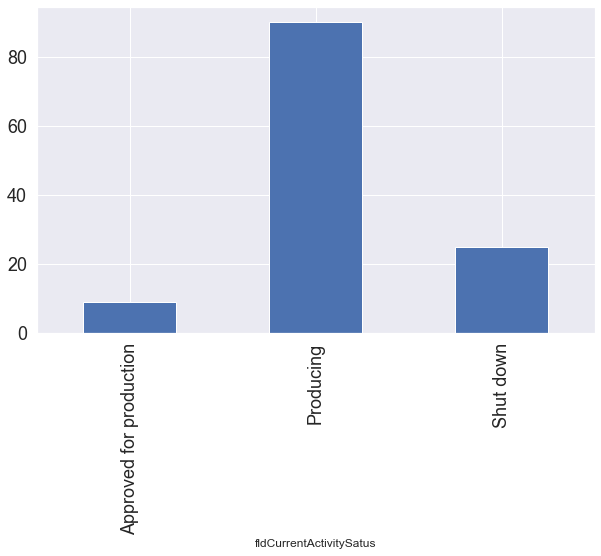

In [25]:
overview.groupby('fldCurrentActivitySatus').size().plot(kind='bar', figsize=(10,6), fontsize=18)

In [26]:
producing_fields = overview[overview['fldCurrentActivitySatus']=='Producing']['cmpLongName'].value_counts()
producing_approved_fields = overview[overview['fldCurrentActivitySatus'].isin(['Approved for production'])]['cmpLongName'].value_counts()
shutdown_fields = overview[overview['fldCurrentActivitySatus']=="Shut down"]['cmpLongName'].value_counts()

print(f"Number of fields: {overview.shape[0]}")
print(f"Number of producing fields: {producing_fields.sum()}")
print(f"Number of producing and approved fields: {producing_approved_fields.sum()}")
print(f"Number of shut down fields: {shutdown_fields.sum()}") # doesn't include 3 NaN entries

Number of fields: 124
Number of producing fields: 90
Number of producing and approved fields: 9
Number of shut down fields: 22


## Status of Fields by Area

fldCurrentActivitySatus  Approved for production  Producing  Shut down
fldMainArea                                                           
Barents Sea                                  1.0        2.0        NaN
North Sea                                    6.0       67.0       24.0
Norwegian Sea                                2.0       21.0        1.0
Column Total                                 9.0       90.0       25.0


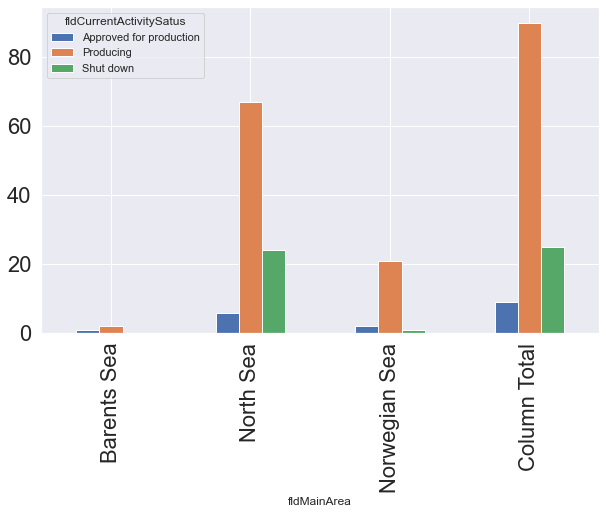

In [27]:
data = overview.groupby(['fldMainArea', 'fldCurrentActivitySatus']).size().unstack()
data.loc['Column Total'] = data.sum(numeric_only=True, axis=0)
print(data)
data.plot(kind='bar', figsize=(10,6), fontsize=22)
plt.show()

# Status

In [28]:
status = load(fields[1])

In [29]:
# status.head()

In [30]:
status.dropna(inplace=True)

status = status.loc[status.groupby('fldName').fldStatusToDate.idxmax(),:]

In [31]:
status['fldStatus'].value_counts()
#  the headings and values look transposed

Approved for production    91
Producing                  24
Shut down                   1
Name: fldStatus, dtype: int64

In [32]:
status['fldName'].nunique()

116

# Operators

In [33]:
operators = load(fields[2])

In [34]:
print(f" Number of Operators: {operators['cmpLongName'].nunique()}")
print(f" Number of Fields: {operators['fldName'].nunique()}")

 Number of Operators: 78
 Number of Fields: 124


In [35]:
# Current Operators don't have a date in the 'fldOperatorTo' field
operators[operators['fldOperatorTo'].isnull()]['cmpLongName'].value_counts() # 121 - doesn't include NaN

Equinor Energy AS                   59
Aker BP ASA                         19
ConocoPhillips Skandinavia AS        9
Vår Energi AS                        5
Wintershall Dea Norge AS             5
Repsol Norge AS                      4
Neptune Energy Norge AS              3
Lundin Energy Norway AS              3
A/S Norske Shell                     3
Total E&P Norge AS                   2
DNO Norge AS                         2
Spirit Energy Norway AS              2
Repsol Sinopec North Sea Limited     1
OKEA ASA                             1
Total E&P UK Ltd                     1
Petrogas NEO UK Ltd                  1
Chrysaor Norge AS                    1
Name: cmpLongName, dtype: int64

# Description

In [36]:
description = load(fields[7])

In [37]:
description.head()

,fldName,fldDescriptionHeading,fldDescriptionText,fldNpdidField,fldDescriptionDateUpdated
0,ALBUSKJELL,Development,Albuskjell is a field in the southern part of ...,43437,2020-02-08
1,ALBUSKJELL,Reservoir,Albuskjell produced gas and condensate from Ma...,43437,2018-03-16
2,ALBUSKJELL,Recovery,The field was produced by pressure depletion.,43437,2017-04-11
3,ALBUSKJELL,Transport,The well stream was transported via pipeline t...,43437,2018-03-16
4,ALBUSKJELL,Status,The field was shut down in 1998 and the platfo...,43437,2020-02-08
